# SARIMA

$\operatorname{SARIMA}$ stands for 

- **S**easonal
- **A**uto 
- **R**egressive 
- **I**ntegrated 
- **M**oving
- **A**verage.

## What we will accomplish

In this notebook we will:
- Motivate the SARIMA model
- Give a precise specification of the model
- Discuss how to choose the hyperparamaters.
- Demonstrate how to fit a SARIMA model in python

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from seaborn import set_style
set_style("whitegrid")

## Mathematical Motivation

Wold's Decomposition Theorem states that every covariance stationary time series $y_t$ with $\mathbb{E}(y_t) = 0$ can be decomposed as

$$
y_t =  \eta_t + \sum_{j=0}^{\infty} d_j \epsilon_{t-j}
$$

where 

- $\epsilon_{t} \sim \operatorname{NID}(0,\sigma^2)$
- $d_0 = 1$
- $\displaystyle \sum_0^\infty d_j^2$ is finite.
- $P(\eta_{t+s} | y_t, y_{t-1}, y_{t-2}, \dots) = \eta_{t+s}$ for all $s>0$

So $y_t$ can, in essense, be represented as an $\operatorname{MA}(\infty)$ process plus a "deterministic part" $\eta_t$.

A great exposition written by Prof. Lawrence Christiano can be found [here](lecture_7_assets/wold.pdf).

This is the theoretical justification for using $\operatorname{MA}(q)$ models, which are finite approximations.

 Although Wold's theorem says that we could always use $\operatorname{MA}(q)$, the value of $q$ might be quite large.  Estimating this many parameters might require a lot of data.  Wold's theorem also tells us that an $\operatorname{AR}(p)$ process can be written as an $\operatorname{MA}(\infty)$, but it is nicer to only estimate $p$ parameters than infinitely many parameters!  
 
 Including both $\operatorname{AR}(p)$ and $\operatorname{MA}(q)$ parts of our model can account for both types of behavior while limiting the number of parameters to be estimated.  This leads us to $\operatorname{ARMA}$ models.

## Autoregressive Moving Average (ARMA) models

Combining an $\text{AR}(p)$ and $\text{MA}(q)$ sequence gives an $\text{ARMA}(p,q)$ process, that is:

$$
y_t = \alpha_1 y_{t-1} + \dots + \alpha_{p} y_{t-p} + \epsilon_t + \beta_1 \epsilon_{t-1} + \dots + \beta_q \epsilon_{t-q}.
$$

From this we can see that if $p=0$, then we have a $\text{MA}(q)$ process, while if $q=0$ we have an $\text{AR}(p)$ process.

We will also introduce some additional notation which will make writing these things down a little easier.

Let $B$ be the backshift operator which takes a time series $t \mapsto y_t$ and returns the backshifted time series $t \mapsto y_{t-1}$. 

Then we can rewrite the $\operatorname{ARMA}$ model as

$$
(1 - \alpha_1 B - \alpha_2 B^2 - \dots - \alpha_p B^p)y_t = (1 + \beta_1 B + \dots + \beta_q B^q) \epsilon_t
$$

If the time series you are attempting to forecast <b>is not</b> stationary, it will not give a good fit or forecast in the long run. This leads to the **I** in the AR**I**MA model.

## Autoregressive Integrated Moving Average (ARIMA) models

An $\operatorname{ARIMA}(p,d,q)$ is 

$$
(1 - \alpha_1 B - \alpha_2 B^2 - \dots - \alpha_p B^p)(1-B)^d y_t = (1 + \beta_1 B + \dots + \beta_q B^q) \epsilon_t
$$
 
$1-B$ is the difference operator which takes $t \mapsto y_t$ and returns $t \mapsto y_{t} - y_{t-1}$.

So $(1-B)^d$ applies the difference operator $d$ times. 

We should choose $d$ so that the differenced time series appears stationary.

Sometimes we see some "seasonality" in our autocorrelation:  only lags which are multiples of a given $s$ appear significant. This leads us to the **S** in **S**ARIMA.

## SARIMA models

$\operatorname{SARIMA}((p,d,q),(P,D,Q,s))$ is 

$$
(1 - \mathfrak{a}_1 B^s - \mathfrak{a}_2 B^{2s} - \dots  - \mathfrak{a}_P B^{Ps})(1 - \alpha_1 B - \alpha_2 B^2 - \dots - \alpha_p B^p)(1-B^s)^D(1-B)^d y_t = (1 + \mathfrak{b}_1 B^s + \mathfrak{b}_2 B^{2s} + \dots  + \mathfrak{b}_Q B^{Qs})(1 + \beta_1 B + \dots + \beta_q B^q) \epsilon_t
$$

Let's write down an example $\operatorname{SARIMA}((0,0,0),(1,0,0,7))$ model in less awesome notation to get a feel for this.  

It is just

$$
(1 - \mathfrak{a}_1 B^7) y_t = \epsilon_t
$$

which translates to

$$
y_t = \mathfrak{a}_1 y_{t-7} + \epsilon_t
$$

In other words, the seasonal part of SARIMA only regresses on lags which are multiples of $s$.

### Simulating some ARIMA data

Let's generate some synthetic data which follows the $\operatorname{ARIMA}(2,1,2)$ process:

$$
y_t - y_{t-1} = 0.5y_{t-1} - 0.2y_{t-2} + \epsilon_{t} + 0.7\epsilon_{t-1} + 0.4\epsilon_{t-2}
$$


In [2]:
import statsmodels.tsa.api as sm

In [3]:
# Code lightly modified from the documentation
np.random.seed(12345)
arparams = np.array([0.5, -0.2])
maparams = np.array([0.7, 0.4])
ar = np.r_[1, -arparams] # add zero-lag and negate
ma = np.r_[1, maparams] # add zero-lag
y = sm.arma_generate_sample(ar, ma, 1000).cumsum() # taking cumulative sum of ARMA process to get y, i.e. "integrating" once.

model = sm.ARIMA(y, order = (2, 1, 2)).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 1000
Model:                 ARIMA(2, 1, 2)   Log Likelihood               -1397.218
Date:                Mon, 18 Mar 2024   AIC                           2804.436
Time:                        14:33:50   BIC                           2828.970
Sample:                             0   HQIC                          2813.761
                               - 1000                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4510      0.078      5.755      0.000       0.297       0.605
ar.L2         -0.1954      0.060     -3.266      0.001      -0.313      -0.078
ma.L1          0.7489      0.073     10.219      0.000       0.605       0.893
ma.L2          0.4384      0.049      8.947      0.000       0.342       0.534
sigma2         0.9586      0.042     22.591      0.000       0.875       1.042
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                 3.81
Prob(Q):                              1.00   Prob(JB):                         0.15
Heteroskedasticity (H):               0.87   Skew:                             0.14
Prob(H) (two-sided):                  0.21   Kurtosis:                         3.09
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

The summary shows that we obtained good estimates of the true parameters!

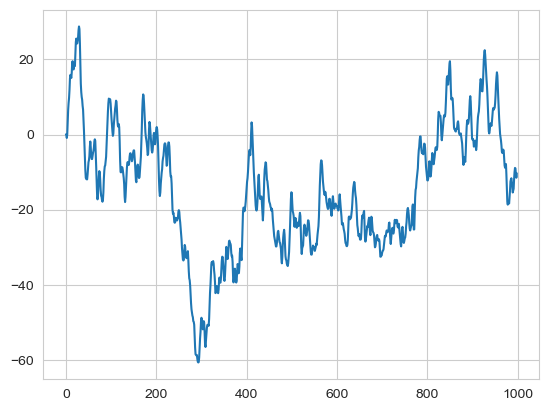

In [4]:
# Plot of the time series

plt.plot(range(999), y[1:]) #
plt.show()

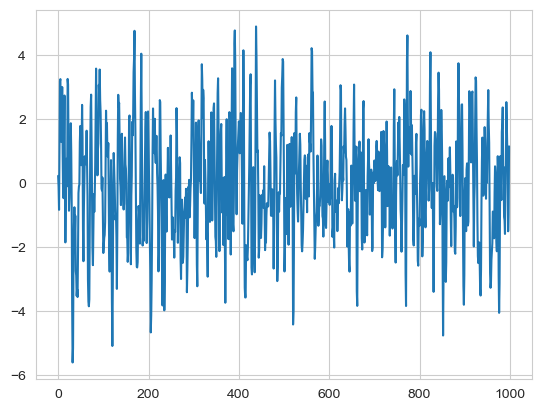

In [5]:
# plot of the first differences

plt.plot(range(999), y[1:] - y[:-1]) 
plt.show()

In [6]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

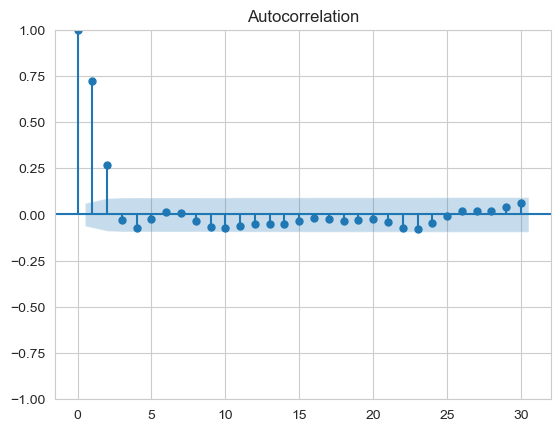

In [7]:
plot_acf(y[1:] - y[:-1])
plt.show()

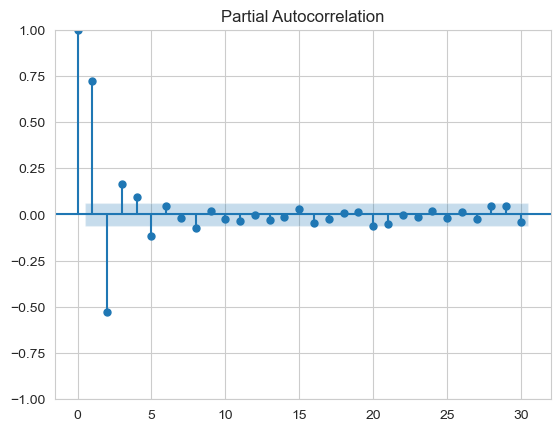

In [8]:
plot_pacf(y[1:] - y[:-1])
plt.show()

Remember that 

- the order of a pure MA model can be identified from the ACF plot, and it will appear to exponentially decay on the PACF plot.
- the order of a pure AR model can be identified from the PACF plot, and it will appear to exponentially decay on the ACF plot.

An ARMA model will have some combination of these and this can muddle identification of the hyperparameters from these plots.  In practice hyperparameter selection is usually done automatically either in cross validation or by selecting the model with the lowest [Akaike information criterion (AIC)](https://en.wikipedia.org/wiki/Akaike_information_criterion).  However these plots can still be useful, as we will see a bit later when we do some forecasting on real data.


### Using SARIMA on real data

We introduce a new dataset sourced from [Kaggle](https://www.kaggle.com/competitions/demand-forecasting-kernels-only/data).

The original dataset was quite large:  it tracked the sales of $50$ different items in $10$ different store locations over $5$ years.  I trimmed it down to sales of one product at one particular grocery store over a $5$ year period.

In [9]:
df_train = pd.read_csv('../../data/sales_train.csv', index_col=0, parse_dates=['date']) # 2013,2014,2015, 2016
df_test = pd.read_csv('../../data/sales_test.csv', index_col=0, parse_dates=['date']) # 2017

In [10]:
df_train.head()

,date,sales
0,2013-01-01,13
1,2013-01-02,11
2,2013-01-03,14
3,2013-01-04,13
4,2013-01-05,10


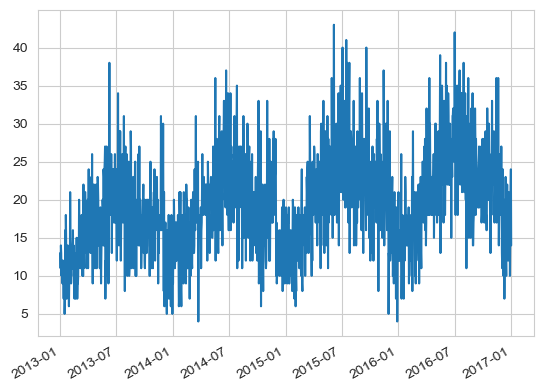

In [11]:
plt.plot(df_train.date, df_train.sales)
plt.gcf().autofmt_xdate()

plt.show()

There appears to be both an upward trend and yearly seasonality.  However, the seasonality is fairly complex:  a "double bump" structure becomes more apparent when looking at the rolling average:

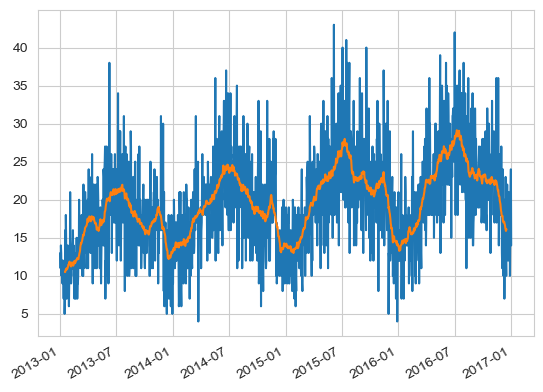

In [12]:
plt.plot(df_train.date, df_train.sales)
plt.plot(df_train.date.iloc[15:-15], df_train.sales.rolling(30).mean().iloc[30:])
plt.gcf().autofmt_xdate()

plt.show()

Because of the complexity of the seasonal component, it would be reasonable to keep a rolling average as the baseline.  

For the sake of making things pretty I instead choose to do a linear regression of the form:

$$
y_t = \beta_0 +\beta_1t + \sum_{j=0}^5 \phi_j \cos\left(\frac{(2+j)\pi}{365} t\right) + \psi_j\sin\left(\frac{(2+j)\pi}{365} t\right)
$$

In [13]:
from sklearn.linear_model import LinearRegression

In [14]:
train_times = df_train.index.values
cosines = np.stack([np.cos((2+i)*np.pi*train_times/365) for i in range(5)]  , axis = 1)
sines = np.stack([np.sin((2+i)*np.pi*train_times/365) for i in range(5)]  , axis = 1)
train_features = np.concatenate([train_times.reshape(-1,1), cosines, sines], axis = 1)

lr = LinearRegression()
lr.fit(train_features,df_train.sales)

LinearRegression()

In [15]:
lr_train_preds = lr.predict(train_features)
lr_train_res = df_train.sales - lr_train_preds

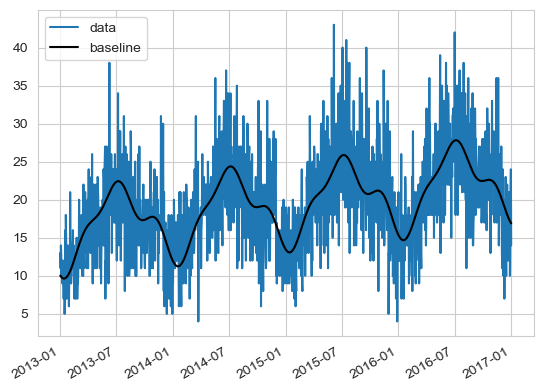

In [16]:
plt.plot(df_train.date, df_train.sales, label = 'data')
plt.plot(df_train.date, lr_train_preds, 'k',label = 'baseline')
plt.gcf().autofmt_xdate()
plt.legend()
plt.show()

It would have been difficult to capture the extra "bump" towards the end of the year without the Fourier component (or by doing a seasonal rolling average).

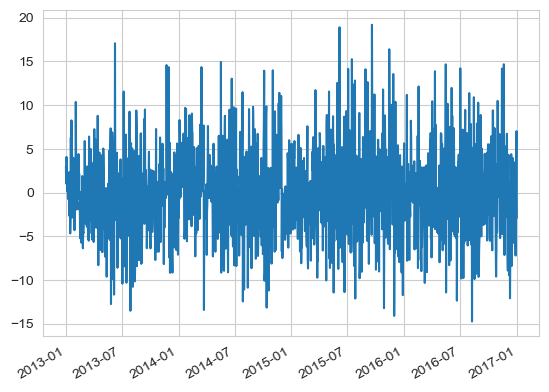

In [17]:
plt.plot(df_train.date, lr_train_res)
plt.gcf().autofmt_xdate()

plt.show()

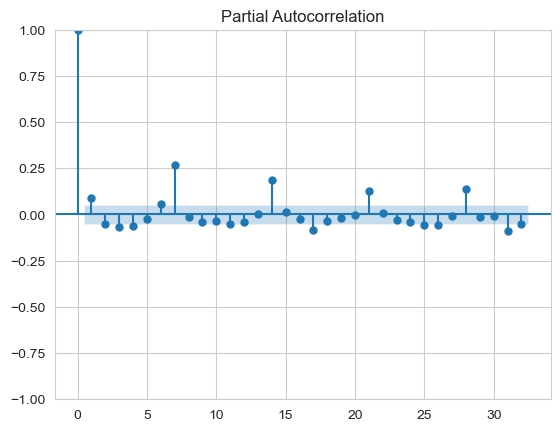

In [18]:
plot_pacf(lr_train_res)
plt.show()

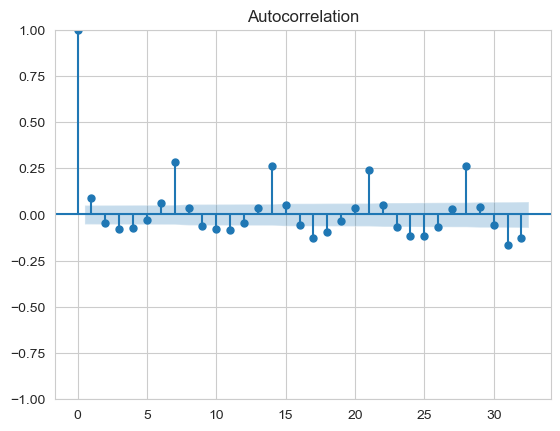

In [19]:
plot_acf(lr_train_res)
plt.show()

These plots show clear seaonsal behavior with a period of $7$.  

This makes sense:  our regression was able to account for patterns at the time scale of the whole year.  However since each year begins on a different day of the week, our yearly average is ignoring weekly patterns. People have different shopping habits on the weekend.  Weekly and biweekly pay dates can also contribute to differences in shopping behavior.

Fitting a SARIMA model with a season of $7$ makes sense.  Also, the nearly constant value of the ACF and PACF at lags which are multiples of 7 suggested that I might need to set $D=1$ in the seasonal part.

I played around a bit with the other hyperparameters which took some time, but I skip that play here for brevity.

In [20]:
sarima = sm.ARIMA(lr_train_res, order=(1, 0, 1), seasonal_order=(1, 1, 1, 7))

# Note:  rather than training the linear regression with OLS and then fitting the sarima model to the residuals 
# it would be better to estimate the linear regression parameters and the arima parameters simultaneously.  
# you could do this with something like 
# sm.ARIMA(df_train.sales, order = (1,0,1), seasonal_order = (1,1,1,7), exog = features)
# I avoided doing that in this notebook for two reasons:
# 1. I think doing it this way tells a clear story so it it nice for teaching purposes.
# 2. While I got similar predictive performance doing it the "proper" way I also had a "convergence" issue which didn't come up before.
# I have been unable, as yet, to pinpoint the source of the convergence issue.
 
fitted_sarima = sarima.fit()

In [21]:
sarima_train_preds = lr_train_preds + fitted_sarima.fittedvalues

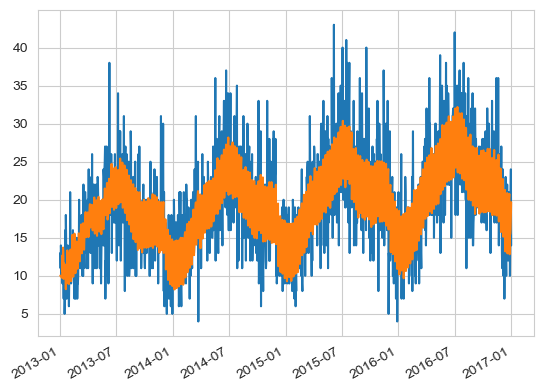

In [22]:
#plt.plot(df_train.date, df_train.sales)
plt.plot(df_train.date, df_train.sales)
plt.plot(df_train.date, sarima_train_preds)
plt.gcf().autofmt_xdate()

plt.show()

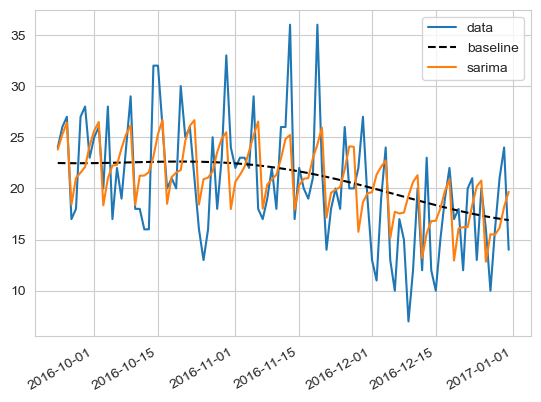

In [23]:
plt.plot(df_train.date.iloc[-100:], df_train.sales.iloc[-100:], label = 'data')
plt.plot(df_train.date.iloc[-100:], lr_train_preds[-100:], '--k',label = 'baseline')
plt.plot(df_train.date.iloc[-100:], sarima_train_preds[-100:], label = 'sarima')
plt.gcf().autofmt_xdate()

plt.legend()

plt.show()

Wow!  We are really doing a good job of modeling the weekly highs and lows here.

Let's check the PACF plot to make sure we are not leaving any autocorrelation "on the table".

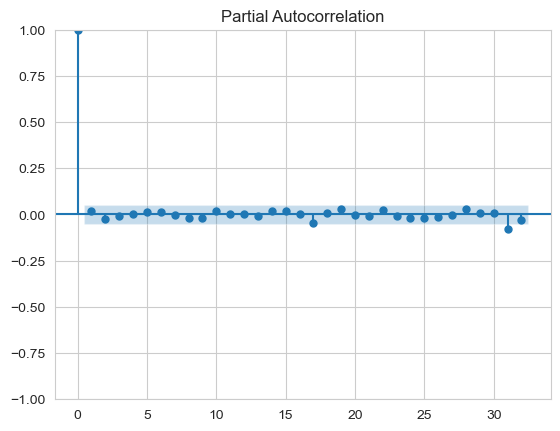

In [24]:
plot_pacf(df_train.sales - (lr_train_preds + fitted_sarima.fittedvalues))
plt.show()

Let's see which model performs better on our test set.

In [25]:
from sklearn.metrics import mean_squared_error

In [26]:
# Making the baseline prediction and arima prediction on the testing data.

test_times = df_test.index.values
test_features = np.concatenate([test_times.reshape(-1,1), cosines[:365,:], sines[:365,:]], axis = 1)

lr_test_preds = lr.predict(test_features)
sarima_test_preds = lr_test_preds + fitted_sarima.forecast(365)

In [27]:
mean_squared_error(df_test.sales,lr_test_preds)

35.243582900171376

In [28]:
mean_squared_error(df_test.sales, sarima_test_preds)

26.337046121120512

Fitting the residuals of our baseline model with SARIMA substantially improved model performance!

Note:  I found that I got similar performance (with better interpretability) by just adding dummies for day of week.  So I personally was not able to get a SARIMA model which really outperformed a well designed linear regression.

# Next Steps for Time Series

This is our final notebook on time series!

We have touched on some of the most basic concepts regarding time series analysis and forecasting. While we do present additional content in the time series `Problem Sessions` and `Practice Problems` notebooks, you may wish to get more detailed information on this subject.

Some useful books are:

1. <a href="http://site.iugaza.edu.ps/nbarakat/files/2010/02/Analysis_of_Time_Series_An_Introduction.pdf">The Analysis of Time Series</a>, by Chris Chatfield

2. <a href="https://mybiostats.files.wordpress.com/2015/03/time-series-analysis-and-its-applications-with-examples-in-r.pdf">Time Series Analysis & its Applications</a>, by Robert H. Shumway and David S. Stoffer.

3. <a href="https://otexts.com/fpp3/">Forecasting: Principles and Practice</a>, by Rob J Hyndman and George Athanasopoulos.

4. Forecasting with Exponential Smoothing: The State Space Approach, by Rob Hyndman, Anne B. Koehler, J. Keith Ord, Ralph D. Snyder

5. Time Series Analysis by James D. Hamilton

--------------------------

This notebook was written for the Erd&#337;s Institute C&#337;de Data Science Boot Camp by Matthew Osborne, Ph. D., 2023.  Modified by Steven Gubkin 2024.

Any potential redistributors must seek and receive permission from Matthew Tyler Osborne, Ph.D. prior to redistribution. Redistribution of the material contained in this repository is conditional on acknowledgement of Matthew Tyler Osborne, Ph.D.'s original authorship and sponsorship of the Erdős Institute as subject to the license (see License.md)